In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import zscore
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Step 1:
Clean and prepare your data: There are several entries where values have been deleted to simulate dirty data. Please clean the data with whatever method(s) you believe is best/most suitable. Note that some of the missing values are truly blank (unknown answers) and thus may be impossible to clean; use your discretion.

In [2]:
metadata = pd.read_csv('Metadata.csv', encoding='cp1252')
data = pd.read_csv('Data for Cleaning & Modeling.csv')
holdout = pd.read_csv('Holdout for Testing.csv')

In [3]:
#updating column names
data.columns=['InterestRate', 'LoanID', 'BorrowerID', 'AmountRequested', 'AmountFunded',
              'InvestorFundedPortion', 'NPayments', 'Grade','Subgrade', 'Job', 'YearsEmployed',
              'OwnershipStatus', 'Income', 'IncomeVerification', 'DateIssued', 'Reason',
              'Category','Title','Zip','State', 'MonthlyPmtToIncome', 'ThirtyDayDelinquencyPast2yrs',
              'DateOfFirstCredit', 'InquiriesPast6mos', 'MosSinceLastDelinquency',
              'MosSinceLastLastPublicRecord', 'OpenCreditLines', 'DerogatoryRecords',
              'RevolvingBalance', 'UtilizationRate','TotalCreditLines','InitialListingStatus']
holdout.columns=['InterestRate', 'LoanID', 'BorrowerID', 'AmountRequested', 'AmountFunded',
                 'InvestorFundedPortion', 'NPayments', 'Grade','Subgrade', 'Job', 'YearsEmployed',
                 'OwnershipStatus', 'Income', 'IncomeVerification', 'DateIssued', 'Reason',
                 'Category','Title','Zip','State', 'MonthlyPmtToIncome', 'ThirtyDayDelinquencyPast2yrs',
                 'DateOfFirstCredit', 'InquiriesPast6mos', 'MosSinceLastDelinquency',
                 'MosSinceLastLastPublicRecord', 'OpenCreditLines', 'DerogatoryRecords',
                 'RevolvingBalance', 'UtilizationRate','TotalCreditLines','InitialListingStatus']

In [4]:
#dropping rows with missing interest rate values (dependent variable in later steps)
data = data.dropna(subset=['InterestRate'])
#drop rows with more than five missing values
data = data.dropna(thresh=3)
#dropping LoanID and BorrowerID because the number doesn't mean anything numerically
data = data.drop(columns=['LoanID', 'BorrowerID'])
#dropping Reason as only 31% of the rows are filled in and they are relatively unique
data = data.drop(columns=['Reason'])
#dropping Title as is not useful
data = data.drop(columns=['Title'])
#87.2% of the MosSinceLastLastPublicRecord is Nan, so dropping that column
data = data.drop(columns=['MosSinceLastLastPublicRecord'])

#drop the same columns in the holdout dataframe
holdout = holdout.drop(columns=['LoanID', 'BorrowerID'])
holdout = holdout.drop(columns=['Reason'])
holdout = holdout.drop(columns=['Title'])
holdout = holdout.drop(columns=['MosSinceLastLastPublicRecord'])

In [5]:
#cleaning up the formating of particular columns; making data easier to work with
data.AmountRequested = pd.to_numeric(data.AmountRequested.replace('[\$,]', '', regex=True))
data.AmountFunded = pd.to_numeric(data.AmountFunded.replace('[\$,]', '', regex=True))
data.InvestorFundedPortion = pd.to_numeric(data.InvestorFundedPortion.replace('[\$,]', '', regex=True))
data.NPayments = pd.to_numeric(data.NPayments.replace(' months', '', regex=True))
data.Zip = pd.to_numeric(data.Zip.replace('x', '', regex=True))
data.InterestRate = pd.to_numeric(data.InterestRate.replace('%', '', regex=True))/100
data.MonthlyPmtToIncome = data.MonthlyPmtToIncome/100
data.UtilizationRate = pd.to_numeric(data.UtilizationRate.replace('%', '', regex=True))/100
data['OpenCreditLines'] = data['OpenCreditLines'].astype(int)
data['TotalCreditLines'] = data['TotalCreditLines'].astype(int)
data['RevolvingBalance'] = data['RevolvingBalance'].astype(int)
data['DerogatoryRecords'] = data['DerogatoryRecords'].astype(int)
data['InquiriesPast6mos'] = data['InquiriesPast6mos'].astype(int)
data['ThirtyDayDelinquencyPast2yrs'] = data['ThirtyDayDelinquencyPast2yrs'].astype(int)
data.InitialListingStatus[data.InitialListingStatus != 'f'] = 0
data.InitialListingStatus[data.InitialListingStatus == 'f'] = 1
data.InitialListingStatus = data.InitialListingStatus.astype(int)
data.IncomeVerification = data.IncomeVerification.astype('category')

#doing same to the holdout data
holdout.AmountRequested = pd.to_numeric(holdout.AmountRequested.replace('[\$,]', '', regex=True))
holdout.AmountFunded = pd.to_numeric(holdout.AmountFunded.replace('[\$,]', '', regex=True))
holdout.InvestorFundedPortion = pd.to_numeric(holdout.InvestorFundedPortion.replace('[\$,]', '', regex=True))
holdout.NPayments = pd.to_numeric(holdout.NPayments.replace(' months', '', regex=True))
holdout.Zip = pd.to_numeric(holdout.Zip.replace('x', '', regex=True))
holdout.MonthlyPmtToIncome = holdout.MonthlyPmtToIncome/100
holdout.UtilizationRate = pd.to_numeric(holdout.UtilizationRate.replace('%', '', regex=True))/100
holdout['OpenCreditLines'] = holdout['OpenCreditLines'].astype(int)
holdout['TotalCreditLines'] = holdout['TotalCreditLines'].astype(int)
holdout['RevolvingBalance'] = holdout['RevolvingBalance'].astype(int)
holdout['DerogatoryRecords'] = holdout['DerogatoryRecords'].astype(int)
holdout['InquiriesPast6mos'] = holdout['InquiriesPast6mos'].astype(int)
holdout['ThirtyDayDelinquencyPast2yrs'] = holdout['ThirtyDayDelinquencyPast2yrs'].astype(int)
holdout.InitialListingStatus[holdout.InitialListingStatus == 'f'] = 0
holdout.InitialListingStatus[holdout.InitialListingStatus != 'f'] = 1
holdout.InitialListingStatus = holdout.InitialListingStatus.astype(int)
holdout.IncomeVerification = holdout.IncomeVerification.astype('category')

In [6]:
#AmountFunded and AmountRequest are 99.8% correlated so dropping AmountFunded
print(np.corrcoef(data.AmountFunded,data.AmountRequested)[0][1])
data = data.drop(columns=['AmountFunded'])
holdout = holdout.drop(columns=['AmountFunded'])

0.9983309345496294


In [7]:
#editing date columns
data.DateIssued = data.DateIssued.apply(lambda x: datetime.strptime(x, '%b-%y'))
data.DateOfFirstCredit = data.DateOfFirstCredit.apply(lambda x: datetime.strptime(x, '%b-%y'))
#assuming these are dates that extend past test dataframe, so used 2015
holdout.DateIssued = holdout.DateIssued.apply(lambda x: datetime.strptime(x+'-2015', '%d-%b-%Y'))

In [8]:
# %%time
# #if the first character is numeric, thats the year, otherwise it starts with a month
# for i in range(len(holdout.DateOfFirstCredit)):
#     if holdout.DateOfFirstCredit[i][0] == '2':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0:2] == '10':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('20'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0:2] == '11':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('20'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0:2] == '12':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('20'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0:2] == '1-':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0] == '3':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0] == '4':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0] == '5':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')
#     elif holdout.DateOfFirstCredit[i][0] == '6':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')        
#     elif holdout.DateOfFirstCredit[i][0] == '7':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')        
#     elif holdout.DateOfFirstCredit[i][0] == '8':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')        
#     elif holdout.DateOfFirstCredit[i][0] == '9':
#         holdout.DateOfFirstCredit[i] = datetime.strptime(('200'+holdout.DateOfFirstCredit[i]), '%Y-%b')        
#     else:
#         holdout.DateOfFirstCredit[i] = datetime.strptime(holdout.DateOfFirstCredit[i], '%b-%y')

#since that takes forever, I'm saving the output so I don't have to run it again
#holdoutdatesbackup = holdout.DateOfFirstCredit
#holdoutdatesbackup.to_csv("holdoutdatesbackup.csv", index=False, date_format='%Y-%b-%d')
date_parser = pd.datetools.to_datetime
headers = ['col1']
holdoutdatesbackup = pd.read_csv('holdoutdatesbackup.csv', header=None, names=headers, parse_dates=headers)
holdout.DateOfFirstCredit = holdoutdatesbackup
holdout.DateOfFirstCredit = holdout.DateOfFirstCredit.astype(datetime)

In [9]:
data.index = list(range(0,len(data.InterestRate)))

In [10]:
#checking for NaNs
nancount = []
for i in range(len(data.columns)):
    nancount.append(data[data.columns[i]].isna().sum())

df = pd.DataFrame(nancount, data.columns, columns=['NaN Count'])
df[df['NaN Count'] > 0]

,NaN Count
Grade,51866
Subgrade,51866
Job,20256
YearsEmployed,14794
OwnershipStatus,51959
Income,51751
MosSinceLastDelinquency,185456
UtilizationRate,224


In [11]:
#picking to use just the year for dates
data.DateIssued = pd.DatetimeIndex(data.DateIssued).year
data.DateIssued[data.DateIssued > 2015] = (data.DateIssued[data.DateIssued > 2015] - 100)
data.DateIssued = data.DateIssued.astype(int)

#do same for holdout
holdout.DateIssued = pd.DatetimeIndex(holdout.DateIssued).year
holdout.DateIssued[holdout.DateIssued > 2015] = (holdout.DateIssued[holdout.DateIssued > 2015] - 100)
holdout.DateIssued = holdout.DateIssued.astype(int)

Text(0,0.5,'Interest Rate')

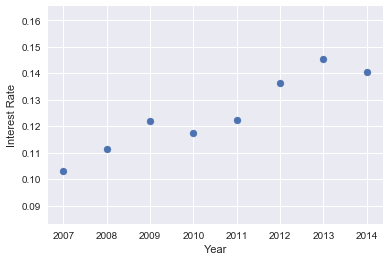

In [12]:
#plotting interest rate vs. date issued
df = data[["DateIssued", "InterestRate"]].groupby(['DateIssued'], as_index=True).mean().sort_values(by='InterestRate', ascending=False)
plt.scatter(df.index, df.InterestRate)
plt.xlabel("Year")
plt.ylabel("Interest Rate")

In [13]:
#picking to use just the year for dates
data.DateOfFirstCredit = pd.DatetimeIndex(data.DateOfFirstCredit).year
data.DateOfFirstCredit[data.DateOfFirstCredit > 2015] = (data.DateOfFirstCredit[data.DateOfFirstCredit > 2015] - 100)
data.DateOfFirstCredit = data.DateOfFirstCredit.astype(int)

#do same for holdout
holdout.DateOfFirstCredit = pd.DatetimeIndex(holdout.DateOfFirstCredit).year
holdout.DateOfFirstCredit[holdout.DateOfFirstCredit > 2015] = (holdout.DateOfFirstCredit[holdout.DateOfFirstCredit > 2015] - 100)
holdout.DateOfFirstCredit = holdout.DateOfFirstCredit.astype(int)

In [14]:
data.index = list(range(0,len(data.InterestRate)))

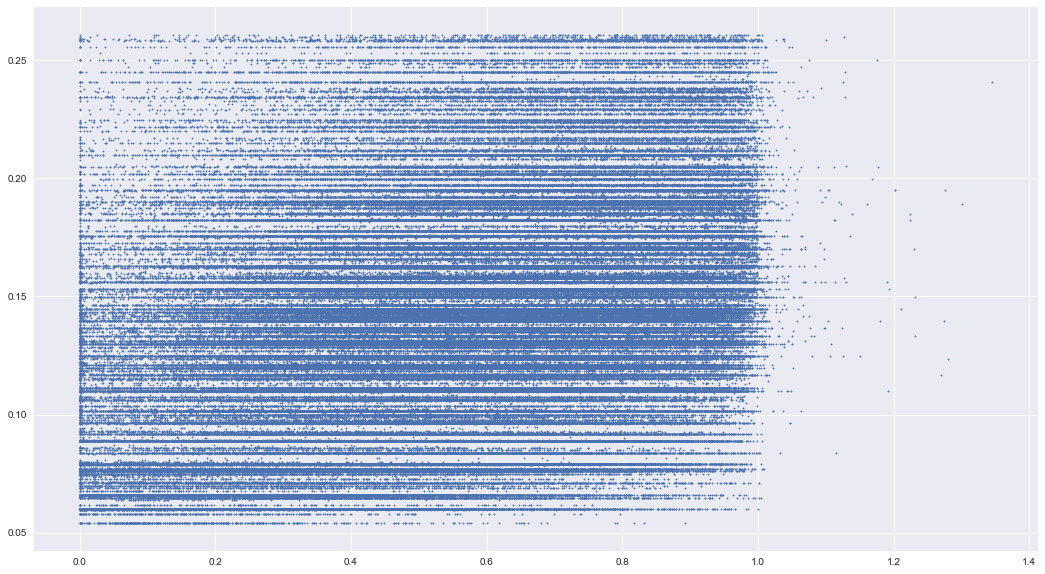

In [15]:
#plotting interest rate vs. utilization rate but removing the outliers to have a better view
df = data[['InterestRate','UtilizationRate']]
dff = holdout[['InterestRate','UtilizationRate']]

df = pd.concat([df,dff])
uts = zscore(df.UtilizationRate.dropna())
df = df.dropna()
uts = (uts >= 3.5)
df = df[~uts[:len(df)]]

plt.figure(figsize=(18, 10))
plt.scatter(df.UtilizationRate,df.InterestRate,s=2)

In [16]:
#224 missing values for UtilizationRate in train dataset, so using median to input value
uts = pd.concat([data.UtilizationRate, holdout.UtilizationRate])
utmedian = uts.median()
data.UtilizationRate[data.UtilizationRate.isna()] = utmedian
holdout.UtilizationRate[holdout.UtilizationRate.isna()] = utmedian

Text(0,0.5,'Interest Rate')

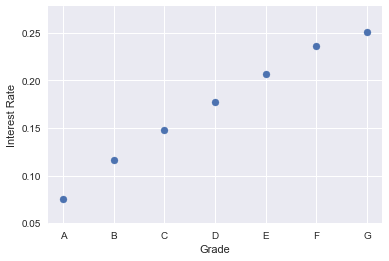

In [17]:
#plotting interest rate vs. grade
df = data[["Grade", "InterestRate"]].groupby(['Grade'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("Grade")
plt.ylabel("Interest Rate")

#converting grades to a numberical score
# grades = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
# data.Grade = data.Grade.map(grades)
# data.Grade = data.Grade.fillna(3) #putting it to 3 as the na mean of the interest rates were closest to the mean of 
# data.Grade = data.Grade.astype(int)
# holdout.Grade = holdout.Grade.map(grades)
# holdout.Grade = holdout.Grade.fillna(3)
# holdout.Grade = holdout.Grade.astype(int)

In [18]:
#converting grades to a dummy variables - one hot encoding
dummy = pd.get_dummies(data.Grade)
data['GradeC'] = dummy['C']
data['GradeD'] = dummy['D']
data['GradeE'] = dummy['E']
data['GradeF'] = dummy['F']
data['GradeG'] = dummy['G']
data = data.drop(columns=['Grade'])

dummy = pd.get_dummies(holdout.Grade)
holdout['GradeC'] = dummy['C']
holdout['GradeD'] = dummy['D']
holdout['GradeE'] = dummy['E']
holdout['GradeF'] = dummy['F']
holdout['GradeG'] = dummy['G']
holdout = holdout.drop(columns=['Grade'])

In [19]:
#converting grades to a numberical score
grades = {"A1": 1, "A2": 2, "A3": 3, "A4": 4, "A5": 5,
          "B1": 6, "B2": 7, "B3": 8, "B4": 9, "B5": 10,
          "C1": 11, "C2": 12, "C3": 13, "C4": 14, "C5": 15,
          "D1": 16, "D2": 17, "D3": 18, "D4": 19, "D5": 20,
          "E1": 21, "E2": 22, "E3": 23, "E4": 24, "E5": 25,
          "F1": 26, "F2": 27, "F3": 28, "F4": 29, "F5": 30,
          "G1": 31, "G2": 32, "G3": 33, "G4": 34, "G5": 35}

data.Subgrade = data.Subgrade.map(grades)
data.Subgrade = data.Subgrade.fillna(36)
data.Subgrade = data.Subgrade.astype(int)
holdout.Subgrade = holdout.Subgrade.map(grades)
holdout.Subgrade = holdout.Subgrade.fillna(36)
holdout.Subgrade = holdout.Subgrade.astype(int)

Text(0,0.5,'Interest Rate')

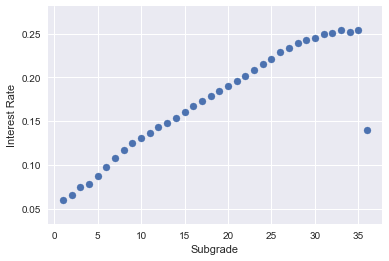

In [20]:
#plotting interest rate vs. grade
df = data[["Subgrade", "InterestRate"]].groupby(['Subgrade'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("Subgrade")
plt.ylabel("Interest Rate")

In [21]:
#converting years employed to a numberical score
yearsemp = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
          '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}

data.YearsEmployed = data.YearsEmployed.map(yearsemp)
data.YearsEmployed = data.YearsEmployed.fillna(0)
data.YearsEmployed = data.YearsEmployed.astype(int)
holdout.YearsEmployed = holdout.YearsEmployed.map(yearsemp)
holdout.YearsEmployed = holdout.YearsEmployed.fillna(0)
holdout.YearsEmployed = holdout.YearsEmployed.astype(int)

Text(0,0.5,'Interest Rate')

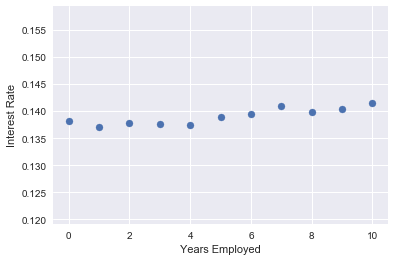

In [22]:
#plotting interest rate vs. YearsEmployed
df = data[["YearsEmployed", "InterestRate"]].groupby(['YearsEmployed'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("Years Employed")
plt.ylabel("Interest Rate")

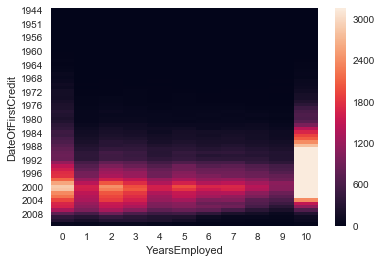

In [23]:
df = pd.crosstab(data.DateOfFirstCredit, data.YearsEmployed, rownames=['DateOfFirstCredit'], colnames=['YearsEmployed'])
ax = sns.heatmap(df, robust=True)

Text(0,0.5,'Interest Rate')

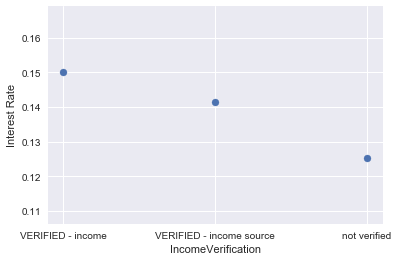

In [24]:
#plotting interest rate vs. IncomeVerification
df = data[["IncomeVerification", "InterestRate"]].groupby(['IncomeVerification'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("IncomeVerification")
plt.ylabel("Interest Rate")

In [25]:
#converting IncomeVerification to a numberical score
incomecat = {"VERIFIED - income": 1, "VERIFIED - income source": 2, "not verified": 3}
data.IncomeVerification = data.IncomeVerification.map(incomecat)
data.IncomeVerification = data.IncomeVerification.fillna(4)
data.IncomeVerification = data.IncomeVerification.astype(int)
holdout.IncomeVerification = holdout.IncomeVerification.map(incomecat)
holdout.IncomeVerification = holdout.IncomeVerification.fillna(4)
holdout.IncomeVerification = holdout.IncomeVerification.astype(int)

Text(0,0.5,'Interest Rate')

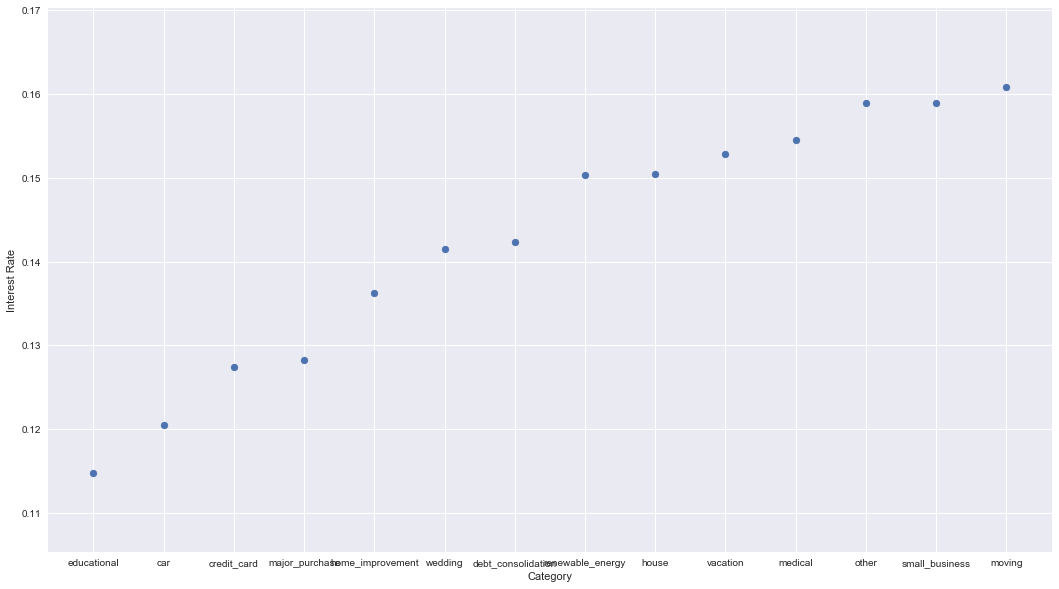

In [26]:
#plotting interest rate vs. Category
df = data[["Category", "InterestRate"]].groupby(['Category'], as_index=True).mean().sort_values(by='InterestRate', ascending=True)
plt.figure(figsize=(18, 10))
plt.scatter(df.index, df.InterestRate)
plt.xlabel("Category")
plt.ylabel("Interest Rate")

In [27]:
#grouping and converting Category to a numberical score
cats = {'educational':1,
        'car':2,
        'credit_card':3, 'major_purchase':3,
        'home_improvement':4,
        'wedding':5, 'debt_consolidation':5,
        'renewable_energy':6,'house':6, 'vacation':6, 'medical':6,
        'other':7, 'small_business':7, 'moving':7}
data.Category = data.Category.map(cats)
data.Category = data.Category.astype(int)
holdout.Category = holdout.Category.map(cats)
holdout.Category = holdout.Category.astype(int)

Text(0,0.5,'Interest Rate')

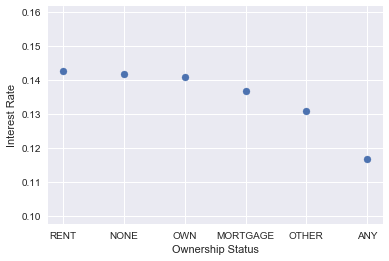

In [28]:
#plotting interest rate vs. Ownership Status
df = data[["OwnershipStatus", "InterestRate"]].groupby(['OwnershipStatus'], as_index=True).mean().sort_values(by='InterestRate', ascending=False)
plt.scatter(df.index, df.InterestRate)
plt.xlabel("Ownership Status")
plt.ylabel("Interest Rate")

In [29]:
#grouping the small groups of Ownership Status with larger ones
data.OwnershipStatus[data.OwnershipStatus == 'ANY'] = 1
data.OwnershipStatus[data.OwnershipStatus == 'NONE'] = 2
data.OwnershipStatus[data.OwnershipStatus == 'OTHER'] = 0
data.OwnershipStatus[data.OwnershipStatus == 'MORTGAGE'] = 1
data.OwnershipStatus[data.OwnershipStatus == 'OWN'] = 2
data.OwnershipStatus[data.OwnershipStatus == 'RENT'] = 3
data.OwnershipStatus[data.OwnershipStatus.isna()] = 2
data.OwnershipStatus = data.OwnershipStatus.astype(int)
holdout.OwnershipStatus[holdout.OwnershipStatus == 'ANY'] = 1
holdout.OwnershipStatus[holdout.OwnershipStatus == 'NONE'] = 2
holdout.OwnershipStatus[holdout.OwnershipStatus == 'OTHER'] = 0
holdout.OwnershipStatus[holdout.OwnershipStatus == 'MORTGAGE'] = 1
holdout.OwnershipStatus[holdout.OwnershipStatus == 'OWN'] = 2
holdout.OwnershipStatus[holdout.OwnershipStatus == 'RENT'] = 3
holdout.OwnershipStatus[holdout.OwnershipStatus.isna()] = 2
holdout.OwnershipStatus = holdout.OwnershipStatus.astype(int)

InterestRate    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

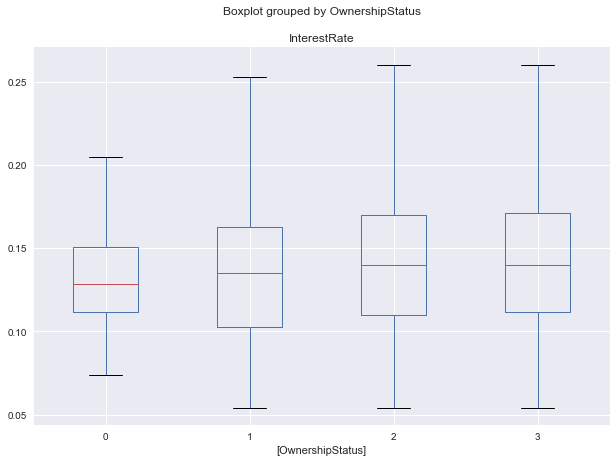

In [30]:
#box plot of interest rates by ownership status
fig, axes = plt.subplots(ncols=1, figsize=(10, 7), sharey=True)
data[['OwnershipStatus','InterestRate']].boxplot(by='OwnershipStatus', return_type='axes', ax=axes)

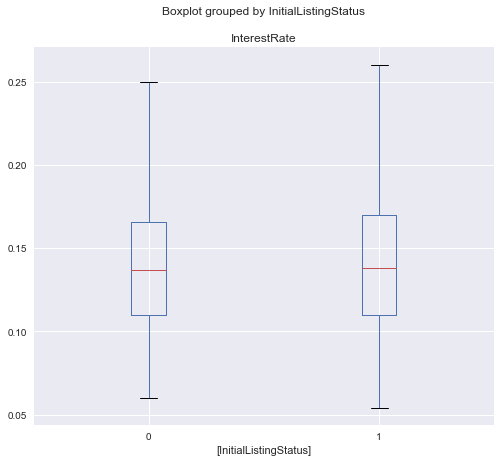

In [31]:
#box plot of interest rates by initial listing status
fig, axes = plt.subplots(figsize=(8, 7), sharey=True)
data[['InitialListingStatus','InterestRate']].boxplot(by='InitialListingStatus', ax=axes)

In [32]:
#initial listing status does not provide additional information so dropping the column
data = data.drop(columns=['InitialListingStatus'])
holdout = holdout.drop(columns=['InitialListingStatus'])

Text(0,0.5,'Interest Rate')

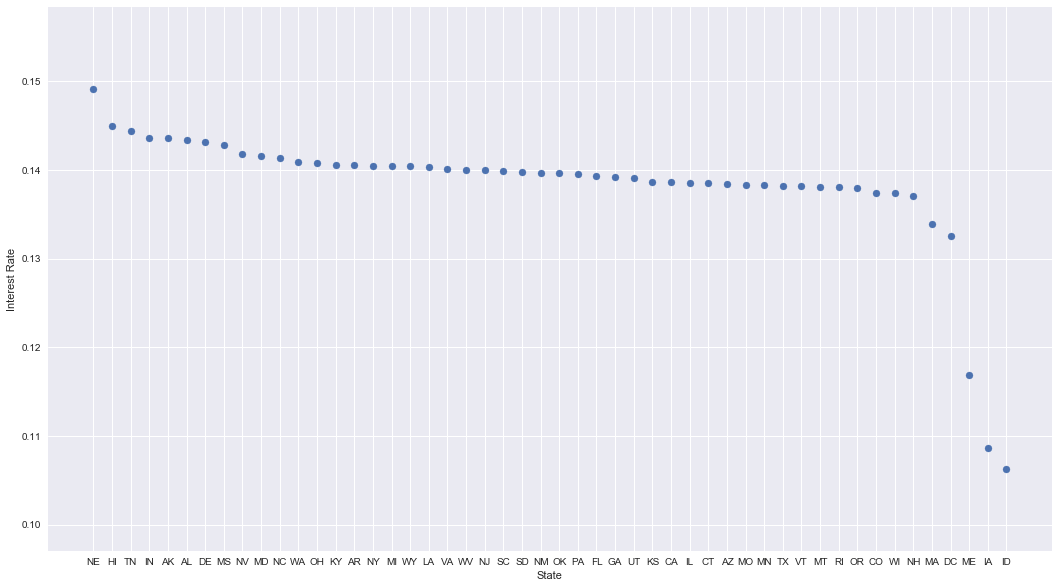

In [33]:
#plotting interest rate vs. State
df = data[["State", "InterestRate"]].groupby(['State'], as_index=True).mean().sort_values(by='InterestRate', ascending=False)
plt.figure(figsize=(18, 10))
plt.scatter(df.index, df.InterestRate)
plt.xlabel("State")
plt.ylabel("Interest Rate")

In [34]:
#grouping and converting States to a numberical score
states = {'NE':1, 'HI':1, 'TN':1, 'IN':1, 'AK':1, 'AL':1, 'DE':1, 'MS':1,
          'NV':2, 'MD':2, 'NC':2, 'WA':2, 'OH':2, 'KY':2, 'AR':2, 'NY':2, 'MI':2, 'WY':2, 'LA':2,         
          'VA':3, 'WV':3, 'NJ':3, 'SC':3, 'SD':3, 'NM':3, 'OK':3, 'PA':3, 'FL':3, 'GA':3, 'UT':3, 'KS':3, 'CA':3, 'IL':3, 'CT':3, 'AZ':3, 'MO':3, 'MN':3, 'TX':3, 'VT':3, 'MT':3, 'RI':3, 'OR':3,'CO':3, 'WI':3, 'NH':3,
          'MA':4, 'DC':4, 'ME':4, 'IA':4, 'ID':4}


# west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID', 'AZ', 'TX', 'NM', 'OK']
# south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
# mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
# north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

# def finding_regions(state):
#     if state in west:
#         return 'West'
#     elif state in south_east:
#         return 'SouthEast'
#     elif state in mid_west:
#         return 'MidWest'
#     elif state in north_east:
#         return 'NorthEast'
# data['Region'] = np.nan
# holdout['Region'] = np.nan
# data['Region'] = data['State'].apply(finding_regions)
# data = data.drop(columns=['State'])
# holdout['Region'] = holdout['State'].apply(finding_regions)
# holdout = holdout.drop(columns=['State'])

# #converting grades to a dummy variables - one hot encoding
# dummy = pd.get_dummies(data.Region)
# data['West'] = dummy['West']
# data['SouthEast'] = dummy['SouthEast']
# data['MidWest'] = dummy['MidWest']
# data['NorthEast'] = dummy['NorthEast']
# data = data.drop(columns=['Region'])
# dummy = pd.get_dummies(holdout.Region)
# holdout['West'] = dummy['West']
# holdout['SouthEast'] = dummy['SouthEast']
# holdout['MidWest'] = dummy['MidWest']
# holdout['NorthEast'] = dummy['NorthEast']
# holdout = holdout.drop(columns=['Region'])

data.State = data.State.map(states)
data.State = data.State.astype(int)
holdout.State = holdout.State.map(states)
holdout.State = holdout.State.astype(int)

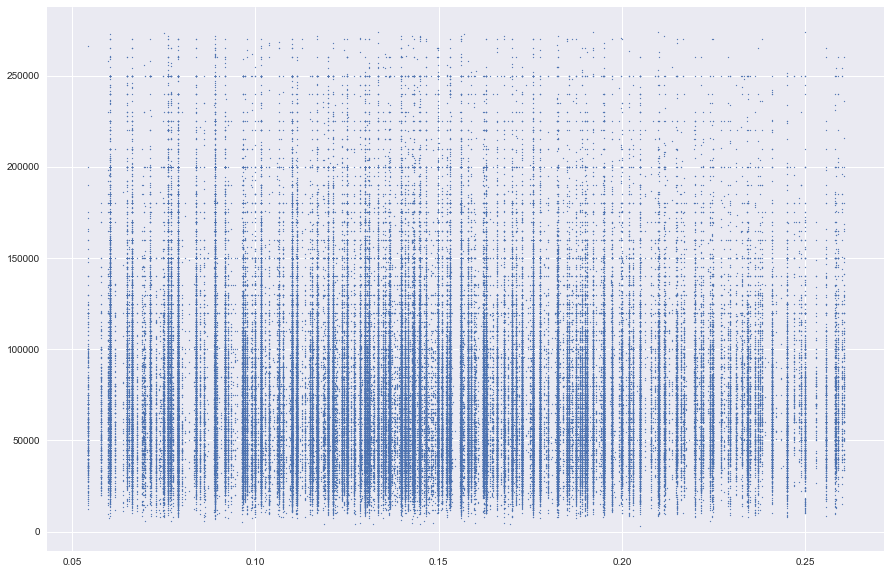

In [35]:
#plotting interest rate vs. income
df = data[['InterestRate','Income']]
dff = holdout[['InterestRate','Income']]

df = pd.concat([df,dff])
uts = zscore(df.Income.dropna())
df = df.dropna()
uts = (uts >= 3.5)
df = df[~uts[:len(df)]]

plt.figure(figsize=(15, 10))
plt.scatter(df.InterestRate,df.Income, s=1)

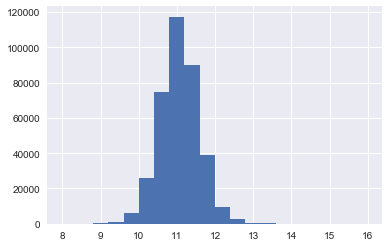

In [36]:
#looking at the distribution of income to figure out how to impute the NaN income values
df = pd.concat([data.Income, holdout.Income])
df = df.dropna().map(lambda i: np.log(i) if i > 0 else 0)

plt.hist(df,bins=20)
plt.show()

logincomemean = df.mean()
logincomestd = df.std()
NullCount = data.Income.isnull().sum()
RandInc = np.random.normal(logincomemean, logincomestd, NullCount)

In [37]:
#filling in NaN values
data.Income[data.Income.isna()] = np.exp(RandInc)
data.Income = data.Income.map(lambda i: np.log(i) if i > 0 else 0)
holdout.Income = holdout.Income.map(lambda i: np.log(i) if i > 0 else 0)

In [38]:
# #cleaning up the Job column
# data['Job'] = data['Job'].str.upper()
# data['Job'] = data['Job'].str.rstrip(' INC')
# data['Job'] = data['Job'].str.rstrip(' LTD')
# data['Job'] = data['Job'].str.rstrip(' CO')
# data['Job'] = data['Job'].str.rstrip(' CORP')
# data['Job'] = data['Job'].str.rstrip(' ORG')
# data['Job'] = data['Job'].str.lstrip(' ')
# data['Job'] = data['Job'].str.rstrip(' ')
# data.Job = data.Job.replace('[\.,|]', '', regex=True)
# data.Job = data.Job.replace('&', 'AND', regex=True)
# data.Job = data.Job.replace('  ', ' ', regex=True)
# data.Job = data.Job.replace('-', ' ', regex=True)
# data.Job = data.Job.replace('/', ' ', regex=True)
# data.Job = data.Job.replace('MGR', 'MANAGER', regex=True)
# data.Job = data.Job.replace('MGMT', 'MANAGEMENT', regex=True)
# data.Job[data.Job == ''] = 'NaN'
# data.Job[data.Job == 'NA'] = 'NaN'

# #for holdout
# holdout['Job'] = holdout['Job'].str.upper()
# holdout['Job'] = holdout['Job'].str.rstrip(' INC')
# holdout['Job'] = holdout['Job'].str.rstrip(' LTD')
# holdout['Job'] = holdout['Job'].str.rstrip(' CO')
# holdout['Job'] = holdout['Job'].str.rstrip(' CORP')
# holdout['Job'] = holdout['Job'].str.rstrip(' ORG')
# holdout['Job'] = holdout['Job'].str.lstrip(' ')
# holdout['Job'] = holdout['Job'].str.rstrip(' ')
# holdout.Job = holdout.Job.replace('[\.,|]', '', regex=True)
# holdout.Job = holdout.Job.replace('&', 'AND', regex=True)
# holdout.Job = holdout.Job.replace('  ', ' ', regex=True)
# holdout.Job = holdout.Job.replace('-', ' ', regex=True)
# holdout.Job = holdout.Job.replace('/', ' ', regex=True)
# holdout.Job = holdout.Job.replace('MGR', 'MANAGER', regex=True)
# holdout.Job = holdout.Job.replace('MGMT', 'MANAGEMENT', regex=True)
# holdout.Job[holdout.Job == ''] = 'NaN'
# holdout.Job[holdout.Job == 'NA'] = 'NaN'

In [39]:
#data['Job'] = data['Job'].astype(str)
#sorted(data.Job.unique())

In [40]:
#don't know how to get information out of this column, so I'm dropping it
data = data.drop(columns=['Job'])
holdout = holdout.drop(columns=['Job'])

In [41]:
#half of the MosSinceLastDelinquency column is missing, so dropping
data = data.drop(columns=['MosSinceLastDelinquency'])
holdout = holdout.drop(columns=['MosSinceLastDelinquency'])

Text(0,0.5,'Interest Rate')

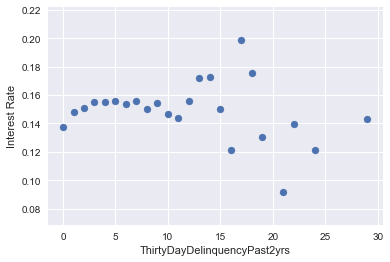

In [42]:
#plotting interest rate vs. ThirtyDayDelinquencyPast2yrs
df = data[["ThirtyDayDelinquencyPast2yrs", "InterestRate"]].groupby(['ThirtyDayDelinquencyPast2yrs'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("ThirtyDayDelinquencyPast2yrs")
plt.ylabel("Interest Rate")

In [43]:
#grouping the data
data.ThirtyDayDelinquencyPast2yrs[data.ThirtyDayDelinquencyPast2yrs>2]=2
holdout.ThirtyDayDelinquencyPast2yrs[holdout.ThirtyDayDelinquencyPast2yrs>2]=2

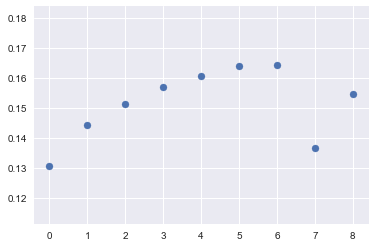

In [44]:
#plotting interest rate vs. Inquiries in the Past 6mos
df = data[["InquiriesPast6mos", "InterestRate"]].groupby(['InquiriesPast6mos'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)

In [45]:
#grouping the data
data.InquiriesPast6mos[data.InquiriesPast6mos>5]=5
holdout.InquiriesPast6mos[holdout.InquiriesPast6mos>5]=5

In [46]:
#checking for NaNs
nancount = []
for i in range(len(data.columns)):
    nancount.append(data[data.columns[i]].isna().sum())

df = pd.DataFrame(nancount, data.columns, columns=['NaN Count'])
df[df['NaN Count'] > 0]

,NaN Count


In [47]:
#looking at outliers
df = pd.concat([data,holdout])

outlierrows = pd.DataFrame()
for i in range(1,len(df.columns)): #or 2?
    outlierrows[i] = (np.array(abs(zscore(df[df.columns[i]])) >= 2.576)) #99% confidence
outlierrows = outlierrows[:len(data)]
outlierrows.columns = data.columns[1:]
outlierrows = outlierrows.drop(['State','InquiriesPast6mos', 'ThirtyDayDelinquencyPast2yrs',
                                'DateOfFirstCredit','Category','DateIssued',"GradeC",'GradeD',
                                'GradeF','GradeG','GradeE'],axis=1)
outlierrows = 1*outlierrows
outlierrows.head(3)

#columns with more than 3 outliers (24 rows)
noutliers = outlierrows.sum(axis=1)
data[noutliers > 3]

,InterestRate,AmountRequested,InvestorFundedPortion,NPayments,Subgrade,YearsEmployed,OwnershipStatus,Income,IncomeVerification,DateIssued,...,OpenCreditLines,DerogatoryRecords,RevolvingBalance,UtilizationRate,TotalCreditLines,GradeC,GradeD,GradeE,GradeF,GradeG
59127,0.2489,28800,28800,36,34,10,1,13.017003,2,2012,...,31,0,114511,0.841,56,0,0,0,0,1
79255,0.1114,35000,34975,36,7,10,1,12.899220,1,2013,...,28,0,1743266,0.295,59,0,0,0,0,0
87123,0.1433,25000,24975,36,11,5,1,12.948010,1,2013,...,28,3,76260,0.748,58,1,0,0,0,0
106278,0.0890,28000,28000,36,5,10,1,12.765688,1,2013,...,25,0,125040,0.536,60,0,0,0,0,0
122120,0.2470,35000,34975,60,31,10,2,12.429216,2,2013,...,28,0,89209,0.958,60,0,0,0,0,1
168323,0.1099,24000,24000,36,7,10,1,12.721886,1,2013,...,25,0,73861,0.624,62,0,0,0,0,0
179329,0.1855,35000,35000,36,17,10,1,12.421184,1,2013,...,36,0,426242,0.636,63,0,1,0,0,0
193208,0.1398,7000,7000,36,11,10,1,12.608199,1,2014,...,27,0,128405,0.813,63,1,0,0,0,0
199388,0.1447,24000,24000,60,36,10,2,13.217674,1,2014,...,36,0,84430,0.578,63,0,0,0,0,0
262355,0.1561,28000,28000,36,16,10,1,12.542545,1,2014,...,30,2,25749,0.630,62,0,1,0,0,0


In [48]:
#there are few data points before 1968 so grouping that data
df = data[["DateOfFirstCredit", "InterestRate"]]
data.DateOfFirstCredit[data.DateOfFirstCredit < 1968] = 1968
holdout.DateOfFirstCredit[holdout.DateOfFirstCredit < 1968] = 1968

Text(0,0.5,'Interest Rate')

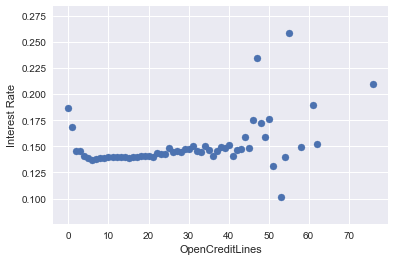

In [49]:
#plotting interest rate vs. ThirtyDayDelinquencyPast2yrs
df = data[["OpenCreditLines", "InterestRate"]].groupby(['OpenCreditLines'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("OpenCreditLines")
plt.ylabel("Interest Rate")

In [50]:
data.OpenCreditLines[data.OpenCreditLines>20]=20
data.OpenCreditLines[data.OpenCreditLines<2]=2
holdout.OpenCreditLines[holdout.OpenCreditLines>20]=20
holdout.OpenCreditLines[holdout.OpenCreditLines<2]=2

Text(0,0.5,'Interest Rate')

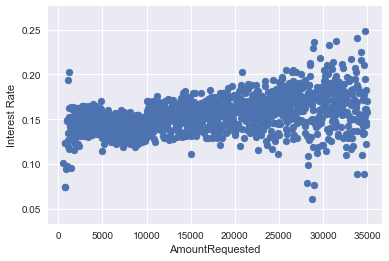

In [51]:
#plotting interest rate vs. AmountRequested
df = data[["AmountRequested", "InterestRate"]].groupby(['AmountRequested'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("AmountRequested")
plt.ylabel("Interest Rate")

Text(0,0.5,'Interest Rate')

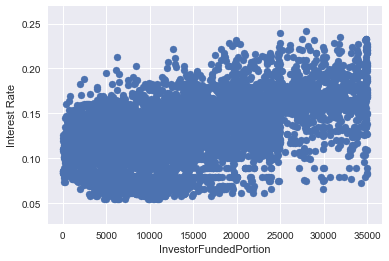

In [52]:
#plotting interest rate vs. InvestorFundedPortion
df = data[["InvestorFundedPortion", "InterestRate"]].groupby(['InvestorFundedPortion'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("InvestorFundedPortion")
plt.ylabel("Interest Rate")

Text(0,0.5,'Interest Rate')

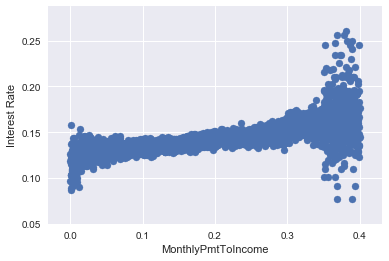

In [53]:
#plotting interest rate vs. MonthlyPmtToIncome
df = data[["MonthlyPmtToIncome", "InterestRate"]].groupby(['MonthlyPmtToIncome'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("MonthlyPmtToIncome")
plt.ylabel("Interest Rate")

0    172066
1     95408
2     43969
3     19780
4      5134
5      2632
Name: InquiriesPast6mos, dtype: int64

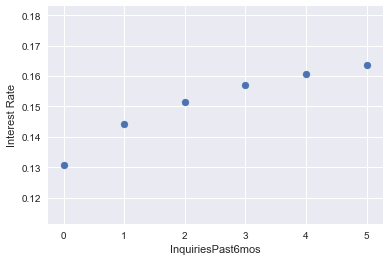

In [54]:
#plotting interest rate vs. InquiriesPast6mos
df = data[["InquiriesPast6mos", "InterestRate"]].groupby(['InquiriesPast6mos'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("InquiriesPast6mos")
plt.ylabel("Interest Rate")
data.InquiriesPast6mos.value_counts()

InterestRate    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

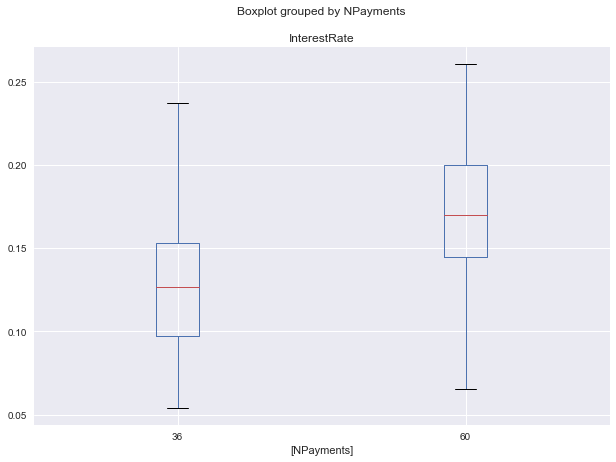

In [55]:
#box plot of interest rates by number of payments
fig, axes = plt.subplots(ncols=1, figsize=(10, 7), sharey=True)
data[['NPayments','InterestRate']].boxplot(by='NPayments', return_type='axes', ax=axes)

Text(0,0.5,'Interest Rate')

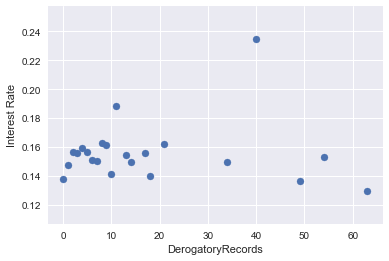

In [56]:
#plotting interest rate vs. DerogatoryRecords
df = data[["DerogatoryRecords", "InterestRate"]].groupby(['DerogatoryRecords'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("DerogatoryRecords")
plt.ylabel("Interest Rate")

In [57]:
#grouping the data
data.DerogatoryRecords[data.DerogatoryRecords>2] = 2
holdout.DerogatoryRecords[holdout.DerogatoryRecords>2] = 2

Text(0,0.5,'Interest Rate')

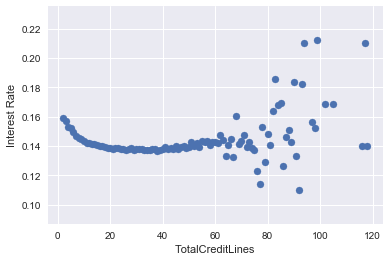

In [58]:
#plotting interest rate vs. TotalCreditLines
df = data[["TotalCreditLines", "InterestRate"]].groupby(['TotalCreditLines'], as_index=True).mean()
plt.scatter(df.index, df.InterestRate)
plt.xlabel("TotalCreditLines")
plt.ylabel("Interest Rate")

In [59]:
#grouping the data
data.TotalCreditLines[data.TotalCreditLines>20] = 20
holdout.TotalCreditLines[holdout.TotalCreditLines>20] = 20

Text(0,0.5,'Interest Rate')

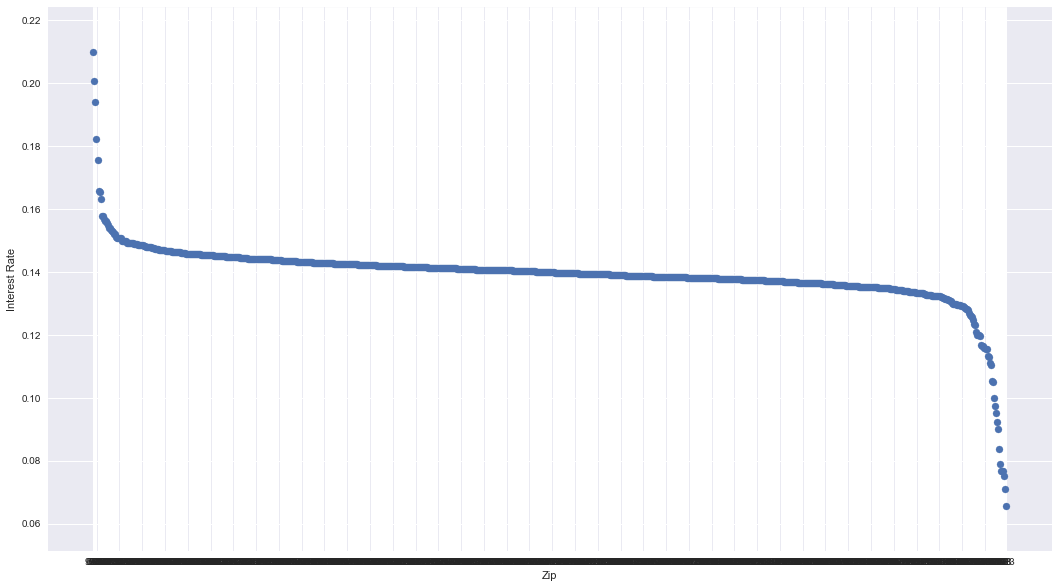

In [60]:
#plotting interest rate vs. Zip
data.Zip = data.Zip.astype(str)
holdout.Zip = holdout.Zip.astype(str)
df = data[["Zip", "InterestRate"]]
df = df.groupby(['Zip'], as_index=True).mean().sort_values(by='InterestRate', ascending=False)
plt.figure(figsize=(18, 10))
plt.scatter(df.index, df.InterestRate)
plt.xlabel("Zip")
plt.ylabel("Interest Rate")

In [61]:
dff = pd.DataFrame()
dff['Zip'] = df.index
dff['IRate'] = np.array(df.InterestRate)
dff['ZipNew'] = pd.cut(dff['IRate'], 7)
dff['ZipNew'] = dff['ZipNew'].astype(str)

In [62]:
zipmap = {"(0.189, 0.21]":'1', "(0.169, 0.189]":'2', "(0.148, 0.169]":'3', "(0.128, 0.148]":'4', 
          "(0.107, 0.128]":'5', '(0.0863, 0.107]':'6', '(0.0656, 0.0863]':'7'}
dff.ZipNew = dff.ZipNew.map(zipmap)

In [63]:
data = data.join(dff.set_index('Zip'), on='Zip').drop(columns=['IRate', 'Zip'])
data.ZipNew = data.ZipNew.astype(int)
holdout = holdout.join(dff.set_index('Zip'), on='Zip').drop(columns=['IRate', 'Zip'])
holdout.ZipNew[holdout.ZipNew.isna()] = 4
holdout.ZipNew = holdout.ZipNew.astype(int)

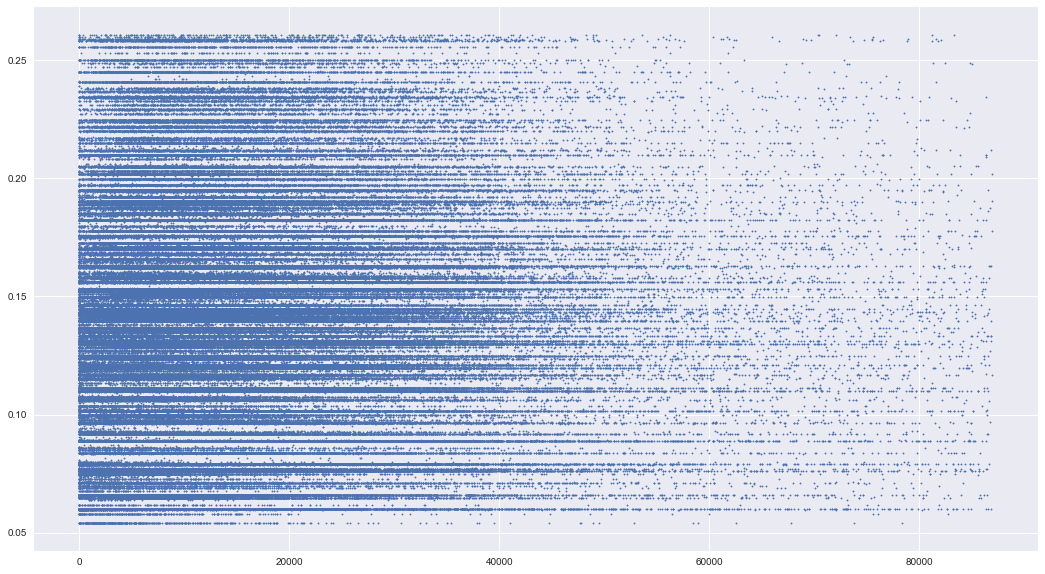

In [64]:
#plotting interest rate vs. RevolvingBalance  but removing the outliers to have a better view
df = data[['InterestRate','RevolvingBalance']]
dff = holdout[['InterestRate','RevolvingBalance']]

df = pd.concat([df,dff])
uts = zscore(df.RevolvingBalance.dropna())
df = df.dropna()
uts = (uts >= 3.5)
df = df[~uts[:len(df)]]

plt.figure(figsize=(18, 10))
plt.scatter((df.RevolvingBalance),df.InterestRate,s=2)

### Step 2:
Build your models: Please build machine learning/statistical models in Python to predict the interest rate assigned to a loan. When writing the code associated with each model, please have the first part produce and save the model, followed by a second part that loads and applies the model.

In [65]:
#make train and test
labels = np.array(data['InterestRate'])
features = data.drop('InterestRate', axis = 1)
rs = 100

from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = rs)

In [66]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(train_features, train_labels)
pred3 = linreg.predict(test_features)
acc_linreg = round(linreg.score(test_features, test_labels) * 100, 2)
print('Accuracy: {:}%'.format(acc_linreg))

Accuracy: 78.6%


In [67]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=100, random_state=rs)
dt.fit(train_features, train_labels)
pred2 = dt.predict(test_features)
acc_dt = round(dt.score(test_features, test_labels) * 100, 2)
print('Accuracy: {:}%'.format(acc_dt))

from sklearn.model_selection import cross_val_score
MSE_CV_scores = - cross_val_score(dt, train_features, train_labels, cv=10, scoring='neg_mean_squared_error', n_jobs=-1) 
rmse_CV = (MSE_CV_scores.mean())**(1/2)
print('CV RMSE: {:.3f}'.format(rmse_CV))

Accuracy: 84.18%
CV RMSE: 0.018


In [68]:
%%time

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state = rs)
rf.fit(train_features, train_labels)
pred1 = rf.predict(test_features)

from sklearn.model_selection import cross_val_score
MSE_CV_scores = - cross_val_score(rf, train_features, train_labels, cv=10, scoring='neg_mean_squared_error', n_jobs=-1) 
rmse_CV = (MSE_CV_scores.mean())**(1/2)
print('CV RMSE: {:.3f}'.format(rmse_CV))

acc = round(rf.score(test_features, test_labels) * 100, 3)
print('Accuracy:', acc, '%.')

CV RMSE: 0.012
Accuracy: 92.261 %.
CPU times: user 2min 49s, sys: 1.13 s, total: 2min 50s
Wall time: 8min 22s


In [69]:
#Accuracy: 92.3859 %.

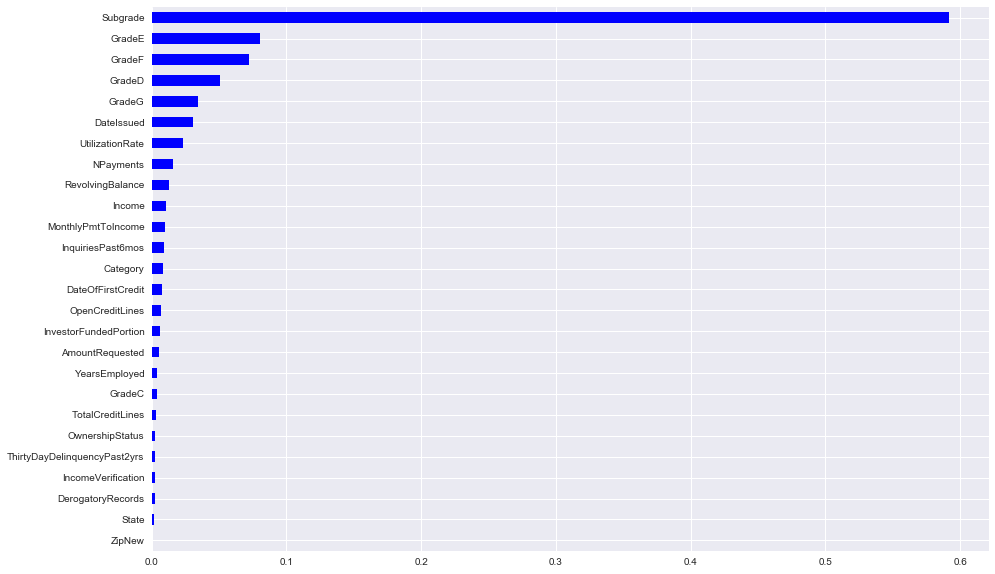

In [70]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,index = features.columns)
sorted_importances_rf = importances_rf.sort_values()

plt.figure(figsize=(15, 10))
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

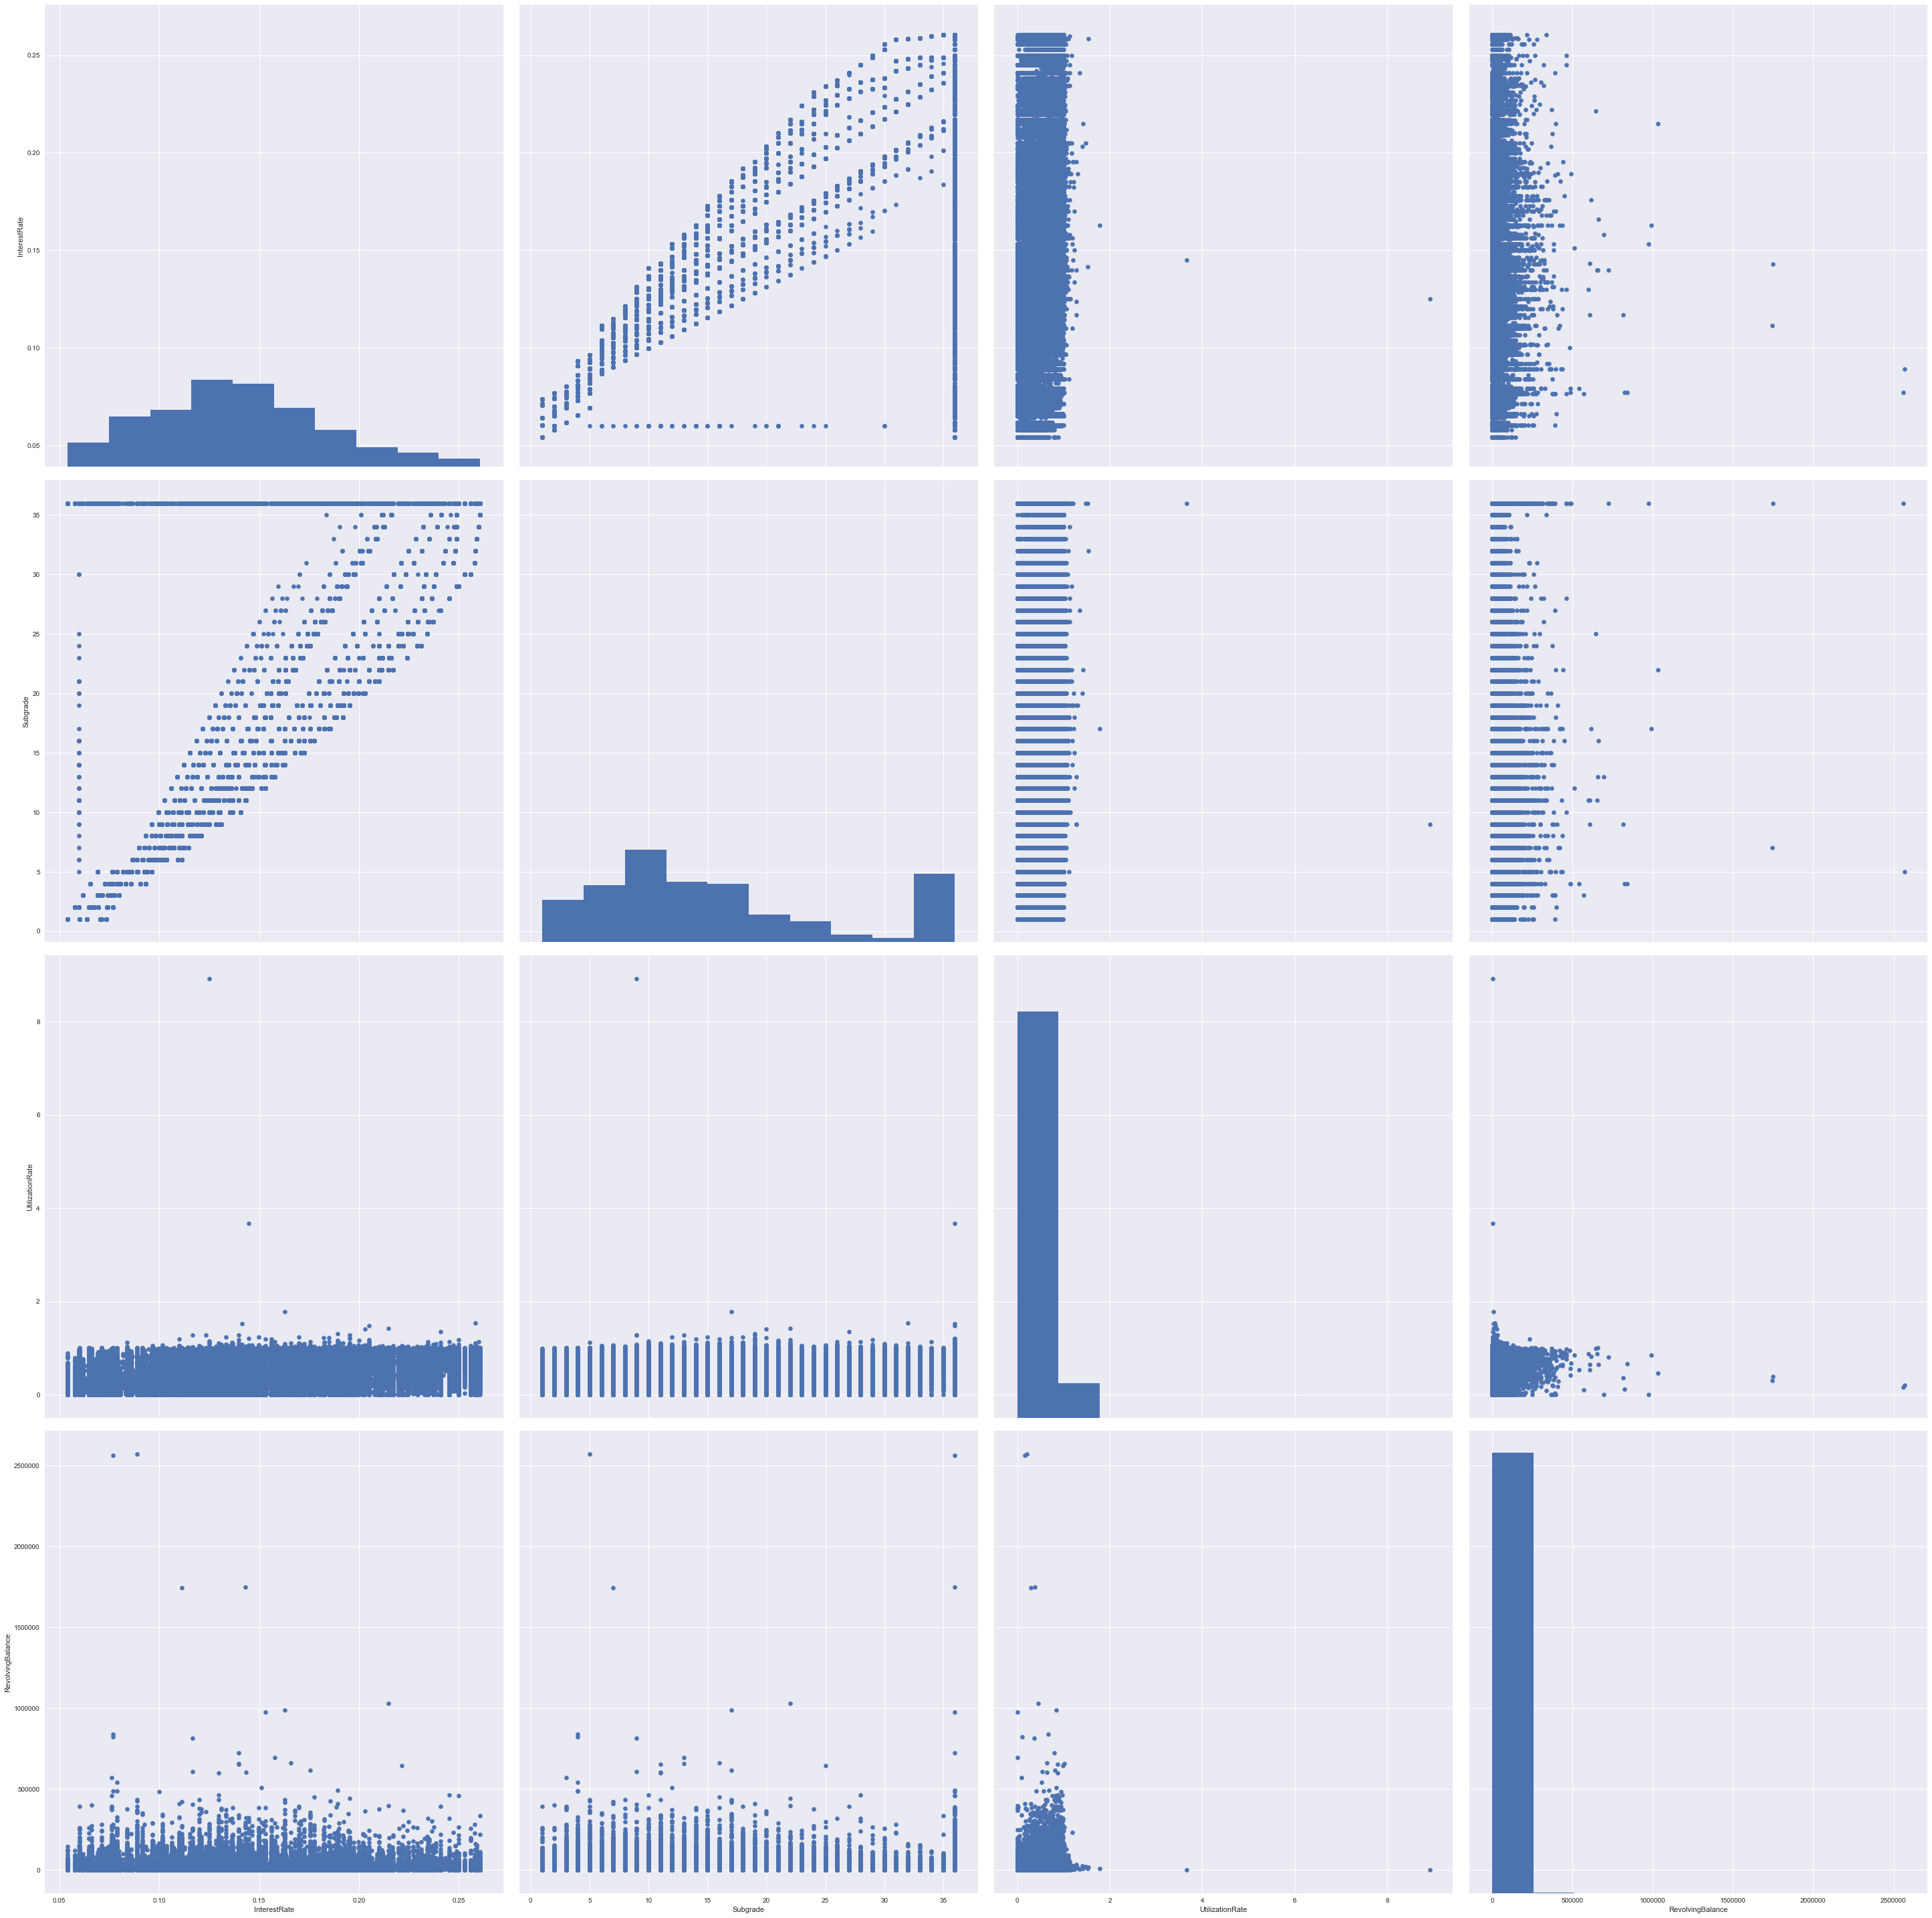

In [71]:
df = data[['InterestRate','Subgrade','UtilizationRate','RevolvingBalance']]

ax = sns.PairGrid(df, size=10)
ax = ax.map_diag(plt.hist)
ax = ax.map_offdiag(plt.scatter, s=40)

In [72]:
%%time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor as XGBR
xgb = XGBR(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5, colsample_bytree=1, max_depth=10)
xgb.fit(train_features,train_labels)
predictions = xgb.predict(test_features)

CPU times: user 1min 4s, sys: 103 ms, total: 1min 4s
Wall time: 1min 4s


In [73]:
from sklearn.metrics import explained_variance_score
acc = explained_variance_score(predictions,test_labels)
print('Accuracy: {:.3f}%'.format(acc*100))

from sklearn.metrics import mean_squared_error as MSE
mse_test = MSE(test_labels, predictions)
rmse_test = mse_test**(1/2)
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Accuracy: 92.345%
Test set RMSE of gb: 0.012


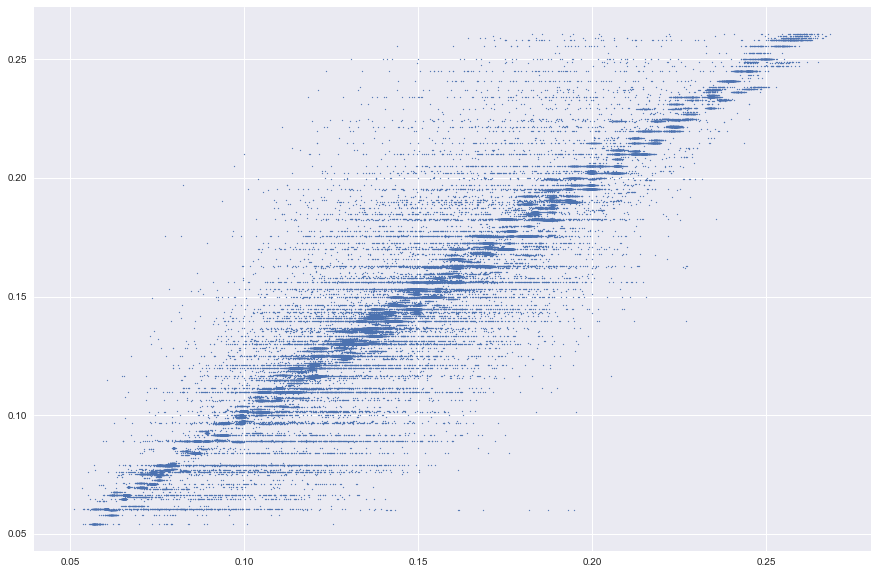

In [74]:
plt.figure(figsize=(15, 10))
plt.scatter(predictions,test_labels, s=1)

### Step 3:
Test your models using the data found within the "Holdout for Testing" file. Save the results of the final model (remember you will only predict the first column in holdout test set with your best model results) in a single, separate CSV titled "Results from" *insert your name or UChicago net ID.

In [75]:
holdout = holdout.drop('InterestRate', axis = 1)
predictions = xgb.predict(holdout)

In [76]:
Submission = pd.DataFrame()
Submission['PredictedInterestRate'] = predictions
Submission.to_csv("Loan Results from eitrheim.csv", index=False)

### Step 4:
Submit your work: Please submit all of your code for cleaning, prepping, and modeling your data, your "Results" file, a brief write-up comparing the pros and cons of the modeling techniques you used (no more than a paragraph). Your work will be scored on techniques used (appropriateness and complexity), model performance - measured by RMSE - on the data hold out, an understanding of the techniques you compared in your write-up, and your overall code.

Linear regression is the fastest model to run and easiest to understand the output, as you can write it as a relatively simple equation. Yet it results in the lowest accuracy score on the test set. Decision Trees results in slightly better results yet is slower. I liked using Random Forest as I could look at the important factors afterwards and it had very good results. Incrementally better is XGBRegressor, but it took the longest amount of time to run and made my computer sound like an airplane taking off.